### Imports

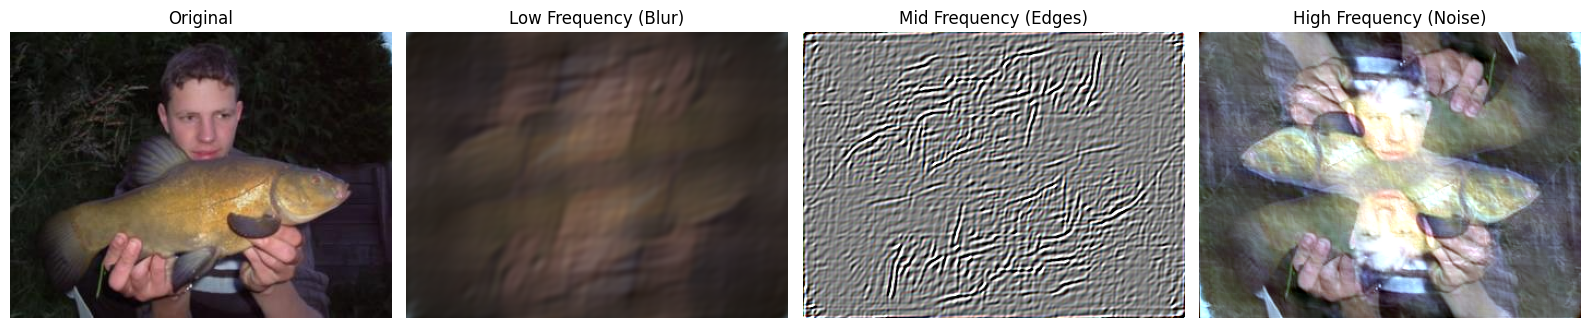

In [21]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# =========================
# CONFIG
# =========================
IMAGE_PATH = r"E:\HFLF\artifact\recon.JPEG"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# DCT / IDCT IMPLEMENTATION
# =========================
def dct_2d(x):
    return torch.fft.fft2(x, norm="ortho").real

def idct_2d(x):
    return torch.fft.ifft2(x, norm="ortho").real

def apply_dct_batch(x):
    return dct_2d(x)

def apply_idct_batch(x):
    return idct_2d(x)

# =========================
# RADIAL FREQUENCY MASKS
# =========================
def radial_mask(h, w, cutoff, device):
    yy, xx = torch.meshgrid(
        torch.linspace(0, 1, h, device=device),
        torch.linspace(0, 1, w, device=device),
        indexing="ij"
    )
    r = torch.sqrt(xx**2 + yy**2)
    return (r <= cutoff).float()[None, None, :, :]

# =========================
# VISUALIZATION HELPERS
# =========================
def viz_lf(x):
    return x.clamp(0, 1)

def viz_zero_mean(x, eps=1e-6):
    mean = x.mean(dim=(-2, -1), keepdim=True)
    std = x.std(dim=(-2, -1), keepdim=True)
    x = (x - mean) / (std + eps)
    x = 0.5 + 0.25 * x
    return x.clamp(0, 1)

def show(x, title, fn):
    img = fn(x)[0].permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# =========================
# LOAD IMAGE
# =========================
img = Image.open(IMAGE_PATH).convert("RGB")
x = T.ToTensor()(img).unsqueeze(0).to(DEVICE)

# =========================
# DCT
# =========================
X = apply_dct_batch(x)

_, _, H, W = X.shape

# =========================
# FREQUENCY BANDS
# =========================
lf_mask = radial_mask(H, W, cutoff=0.12, device=DEVICE)
mf_mask = radial_mask(H, W, cutoff=0.30, device=DEVICE) - lf_mask
hf_mask = 1 - radial_mask(H, W, cutoff=0.45, device=DEVICE)

# =========================
# INVERSE DCT
# =========================
x_lf = apply_idct_batch(X * lf_mask)
x_mf = apply_idct_batch(X * mf_mask)
x_hf = apply_idct_batch(X * hf_mask)

# =========================
# VISUALIZATION
# =========================
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
show(x, "Original", lambda z: z)

plt.subplot(1,4,2)
show(x_lf, "Low Frequency (Blur)", viz_lf)

plt.subplot(1,4,3)
show(x_mf, "Mid Frequency (Edges)", viz_zero_mean)

plt.subplot(1,4,4)
show(x_hf, "High Frequency (Noise)", viz_zero_mean)

plt.tight_layout()
plt.show()


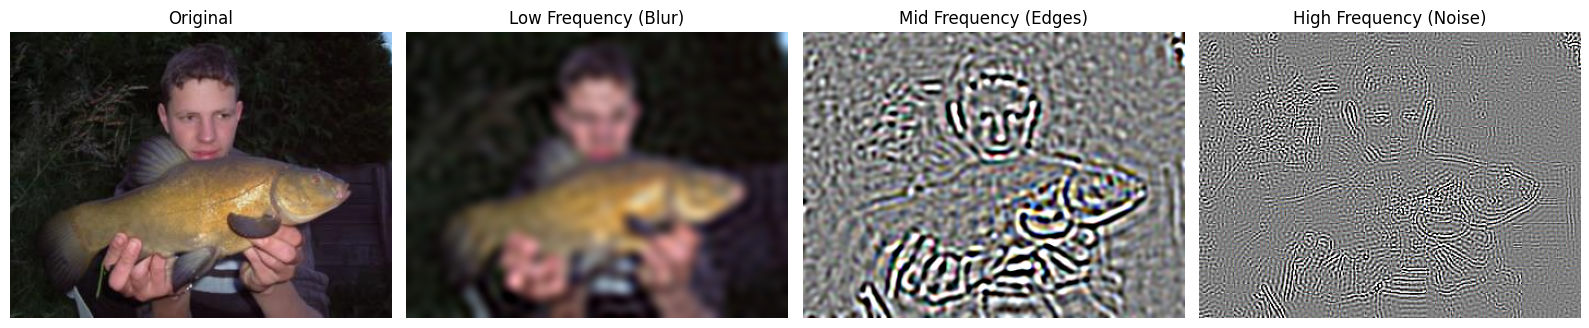

In [22]:
# ============================================================
# Frequency Decomposition Visualization (Correct Version)
# ============================================================

import torch
import torch_dct as dct
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# ============================================================
# CONFIG
# ============================================================
IMAGE_PATH = r"E:\HFLF\artifact\recon.JPEG"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Frequency cutoffs (tuned, sane defaults)
LF_CUTOFF = 0.12
MF_CUTOFF = 0.30
HF_CUTOFF = 0.45

# ============================================================
# LOAD IMAGE
# ============================================================
img = Image.open(IMAGE_PATH).convert("RGB")
x = T.ToTensor()(img).unsqueeze(0).to(DEVICE)   # [1,3,H,W]

# ============================================================
# TRUE DCT / IDCT (DCT-II)
# ============================================================
def apply_dct_batch(x):
    return dct.dct_2d(x, norm="ortho")

def apply_idct_batch(x):
    return dct.idct_2d(x, norm="ortho")

X = apply_dct_batch(x)

_, _, H, W = X.shape

# ============================================================
# RADIAL MASKS (DCT SPACE)
# ============================================================
def radial_mask(h, w, cutoff, device):
    yy, xx = torch.meshgrid(
        torch.linspace(0, 1, h, device=device),
        torch.linspace(0, 1, w, device=device),
        indexing="ij"
    )
    r = torch.sqrt(xx**2 + yy**2)
    return (r <= cutoff).float()[None, None, :, :]

lf_mask = radial_mask(H, W, LF_CUTOFF, DEVICE)
mf_mask = radial_mask(H, W, MF_CUTOFF, DEVICE) - lf_mask
hf_mask = 1 - radial_mask(H, W, HF_CUTOFF, DEVICE)

# ============================================================
# INVERSE DCT (BACK TO IMAGE SPACE)
# ============================================================
x_lf = apply_idct_batch(X * lf_mask)
x_mf = apply_idct_batch(X * mf_mask)
x_hf = apply_idct_batch(X * hf_mask)

# ============================================================
# VISUALIZATION HELPERS (CRITICAL)
# ============================================================
def viz_lf(x):
    # LF is already positive and smooth
    return x.clamp(0, 1)

def viz_zero_mean(x, eps=1e-6):
    # MF / HF are zero-mean oscillatory signals
    mean = x.mean(dim=(-2, -1), keepdim=True)
    std = x.std(dim=(-2, -1), keepdim=True)
    x = (x - mean) / (std + eps)
    x = 0.5 + 0.25 * x   # controlled contrast
    return x.clamp(0, 1)

def show(x, title, fn):
    img = fn(x)[0].permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# ============================================================
# FINAL VISUALIZATION
# ============================================================
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
show(x, "Original", lambda z: z)

plt.subplot(1,4,2)
show(x_lf, "Low Frequency (Blur)", viz_lf)

plt.subplot(1,4,3)
show(x_mf, "Mid Frequency (Edges)", viz_zero_mean)

plt.subplot(1,4,4)
show(x_hf, "High Frequency (Noise)", viz_zero_mean)

plt.tight_layout()
plt.show()
